## 3. Machine Learning

<blockquote> Predicting the consumption and production pattern of prosumers </blockquote>

**Importing Libraries and Loading Data**

In [23]:
import os
import pandas as pd
import lightgbm as lgb
import datetime
import numpy as np
from sklearn.model_selection import train_test_split

#Consumption and Production Data
data = pd.read_csv('C:/Users/Michelle Natali/Downloads/Group 4 - Data/predict-energy-behavior-of-prosumers/merged_production_consumption_installed_capacity_target_and_datetime.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data

,Unnamed: 0,county,county_name,is_business,datetime,is_consumption,target,installed_capacity,product_type,row_id,data_block_id
0,0,0,HARJUMAA,0,2021-09-01 00:00:00,0,0.713,952.89,1,0,0
1,1,0,HARJUMAA,0,2021-09-01 00:00:00,1,96.590,952.89,1,1,0
2,2,0,HARJUMAA,0,2021-09-01 00:00:00,0,0.000,166.40,2,2,0
3,3,0,HARJUMAA,0,2021-09-01 00:00:00,1,17.314,166.40,2,3,0
4,4,0,HARJUMAA,0,2021-09-01 00:00:00,0,2.904,7207.88,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...
2011579,2012107,15,VÕRUMAA,1,2023-05-29 23:00:00,1,188.167,620.00,0,2012107,635
2011580,2012108,15,VÕRUMAA,1,2023-05-29 23:00:00,0,0.000,624.50,1,2012108,635
2011581,2012109,15,VÕRUMAA,1,2023-05-29 23:00:00,1,31.484,624.50,1,2012109,635
2011582,2012110,15,VÕRUMAA,1,2023-05-29 23:00:00,0,0.000,2188.20,3,2012110,635


In [24]:
data = data.drop(columns=['data_block_id','row_id','county_name','Unnamed: 0','installed_capacity'])

**Feature Engineering : Time Series**

For our group project, we use current data to predict the next 48hr data for a certain time. This time, the next 24hr data will be predicted. 

In [33]:
# Generate the target value from 1 days
df_lag24h = data.copy()
df_lag24h['datetime'] = df_lag24h['datetime'] + pd.Timedelta('1 days')
df_lag24h = df_lag24h.rename(columns={'target':'target_lag24h'})
df_train = df_lag24h 
df_train = data.merge(df_lag24h, on=['datetime','is_business','product_type','is_consumption','county'], how='left')

In [34]:
# Generating time features
def get_time_feature(df, col='ts'):
    df_copy = df.copy()

    df_copy['hour'] = df_copy[col].dt.hour
    df_copy['day'] = df_copy[col].dt.day
    df_copy['weekday'] = df_copy[col].dt.weekday
    df_copy['week'] = df_copy[col].dt.isocalendar().week
    df_copy['month'] = df_copy[col].dt.month
    df_copy['quarter'] = df_copy[col].dt.quarter

    return df_copy

df_train = get_time_feature(df_train, col='datetime')
df_train

,county,is_business,datetime,is_consumption,target,product_type,target_lag24h,hour,day,weekday,week,month,quarter
0,0,0,2021-09-01 00:00:00,0,0.713,1,NaN,0,1,2,35,9,3
1,0,0,2021-09-01 00:00:00,1,96.590,1,NaN,0,1,2,35,9,3
2,0,0,2021-09-01 00:00:00,0,0.000,2,NaN,0,1,2,35,9,3
3,0,0,2021-09-01 00:00:00,1,17.314,2,NaN,0,1,2,35,9,3
4,0,0,2021-09-01 00:00:00,0,2.904,3,NaN,0,1,2,35,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011579,15,1,2023-05-29 23:00:00,1,188.167,0,173.048,23,29,0,22,5,2
2011580,15,1,2023-05-29 23:00:00,0,0.000,1,0.000,23,29,0,22,5,2
2011581,15,1,2023-05-29 23:00:00,1,31.484,1,35.217,23,29,0,22,5,2
2011582,15,1,2023-05-29 23:00:00,0,0.000,3,0.000,23,29,0,22,5,2


In [30]:
df_train = df_train.dropna()
df_train

,county,is_business,datetime,is_consumption,target,product_type,target_lag24h
2928,0,0,2021-09-02 00:00:00,0,1.687,1,0.713
2929,0,0,2021-09-02 00:00:00,1,109.366,1,96.590
2930,0,0,2021-09-02 00:00:00,0,0.000,2,0.000
2931,0,0,2021-09-02 00:00:00,1,21.008,2,17.314
2932,0,0,2021-09-02 00:00:00,0,1.003,3,2.904
...,...,...,...,...,...,...,...
2011579,15,1,2023-05-29 23:00:00,1,188.167,0,173.048
2011580,15,1,2023-05-29 23:00:00,0,0.000,1,0.000
2011581,15,1,2023-05-29 23:00:00,1,31.484,1,35.217
2011582,15,1,2023-05-29 23:00:00,0,0.000,3,0.000


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2006688 entries, 2928 to 2011583
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          category      
 1   is_business     category      
 2   datetime        datetime64[ns]
 3   is_consumption  category      
 4   target          float64       
 5   product_type    category      
 6   target_lag24h   float64       
dtypes: category(4), datetime64[ns](1), float64(2)
memory usage: 68.9 MB


In [35]:
cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
        ]
df_train[cat_cols] = df_train[cat_cols].astype("category")
df_train['week'] = df_train['week'].astype("int")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011584 entries, 0 to 2011583
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          category      
 1   is_business     category      
 2   datetime        datetime64[ns]
 3   is_consumption  category      
 4   target          float64       
 5   product_type    category      
 6   target_lag24h   float64       
 7   hour            int32         
 8   day             int32         
 9   weekday         int32         
 10  week            int32         
 11  month           int32         
 12  quarter         int32         
dtypes: category(4), datetime64[ns](1), float64(2), int32(6)
memory usage: 99.8 MB


**Splitting Training, Testing and Validation Datasets**

In [36]:
df_train = df_train.drop(columns=['datetime'])

In [37]:
df_consumption = df_train[df_train['is_consumption'] == 1]
df_production = df_train[df_train['is_consumption'] == 0]

In [38]:
#X = df_train.drop(columns=["target"])
X_consumption = df_consumption.drop(columns=["target"])
y_consumption = df_consumption["target"]
X_production = df_production.drop(columns=["target"])
y_production = df_production["target"]

In [40]:
#train_size = 0.8

#X_consumption_train, X_consumption_test = X.head(int(len(Y)*train_size)) , X.tail(int(len(Y)*(1-train_size)))
#y_consumption_train, y_consumption_test = Y.head(int(len(Y)*train_size)) , Y.tail(int(len(Y)*(1-train_size)))
#X_production_train, X_production_test = X.head(int(len(Y)*train_size)) , X.tail(int(len(Y)*(1-train_size)))
#y_production_train, y_production_test = Y.head(int(len(Y)*train_size)) , Y.tail(int(len(Y)*(1-train_size)))

from sklearn.model_selection import train_test_split

train_size = 0.8

# Filter data for consumption
df_consumption = df_train[df_train['is_consumption'] == 1]
X_consumption = df_consumption.drop(columns=["target"])
y_consumption = df_consumption["target"]

# Splitting data for consumption
X_consumption_train, X_consumption_test, y_consumption_train, y_consumption_test = train_test_split(
    X_consumption, y_consumption, test_size=1 - train_size, random_state=1
)

# Filter data for production
df_production = df_train[df_train['is_consumption'] == 0]
X_production = df_production.drop(columns=["target"])
y_production = df_production["target"]

# Splitting data for production
X_production_train, X_production_test, y_production_train, y_production_test = train_test_split(
    X_production, y_production, test_size=1 - train_size, random_state=1 
)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011584 entries, 0 to 2011583
Data columns (total 12 columns):
 #   Column          Dtype   
---  ------          -----   
 0   county          category
 1   is_business     category
 2   is_consumption  category
 3   target          float64 
 4   product_type    category
 5   target_lag24h   float64 
 6   hour            int32   
 7   day             int32   
 8   weekday         int32   
 9   week            int32   
 10  month           int32   
 11  quarter         int32   
dtypes: category(4), float64(2), int32(6)
memory usage: 84.4 MB


LGBM Regressor

In [42]:
from lightgbm import LGBMRegressor
params = {
    'objective': 'regression_l1', #MAE is used as the objective function of the model
    'verbose': -1 , #this parameter is used to suppress warnings
    'random_state': 1, #this parameter is used for reproducibility purpose

    'n_estimators': 1000,#number of trees
    'learning_rate': 0.05,#learning rate
    'num_leaves': 2**5,#number of leaves in full tree
    'max_depth': 5,#maximum depth of the tree
}

model = LGBMRegressor(**params)
model.fit(X_consumption_train, y_consumption_train)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=32,
              objective='regression_l1', random_state=1, verbose=-1)

In [43]:
from sklearn.metrics import mean_absolute_error
y_predictions_C = model.predict(X_consumption_test)
MAE_C = mean_absolute_error(y_consumption_test, y_predictions_C)
print(f'MAE_C: {MAE_C}')

MAE_C: 57.923305209103084


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

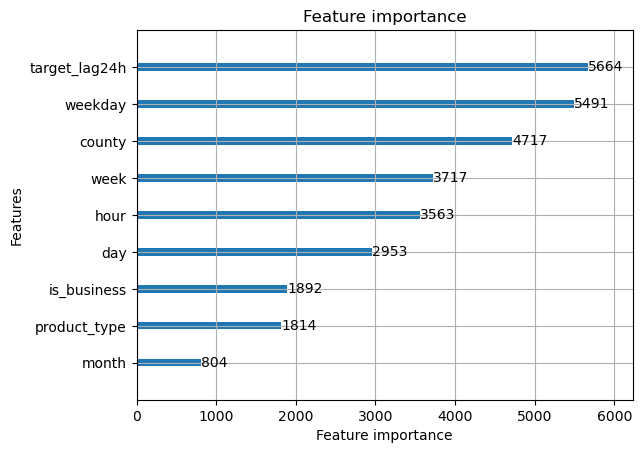

In [44]:
lgb.plot_importance(model)

In [45]:
from lightgbm import LGBMRegressor
params = {
    'objective': 'regression_l1', #MAE is used as the objective function of the model
    'verbose': -1 , #this parameter is used to suppress warnings
    'random_state': 1, #this parameter is used for reproducibility purpose

    'n_estimators': 1000,#number of trees
    'learning_rate': 0.05,#learning rate
    'num_leaves': 2**5,#number of leaves in full tree
    'max_depth': 5,#maximum depth of the tree
}

model = LGBMRegressor(**params)
model.fit(X_production_train, y_production_train)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=32,
              objective='regression_l1', random_state=1, verbose=-1)

In [46]:
from sklearn.metrics import mean_absolute_error
y_predictions = model.predict(X_production_test)
MAE_P = mean_absolute_error(y_production_test, y_predictions)
print(f'MAE_P: {MAE_P}')

MAE_P: 39.093017044818474


LGBM GPU Trainer

In [54]:
import lightgbm as lgb

params = {
    'num_leaves': 38,
    'min_data_in_leaf': 50,
    'objective': 'regression',
    'max_depth': -1,
    'learning_rate': 0.1,
    'device': 'gpu'
}

trn_data_C = lgb.Dataset(X_consumption_train, label=y_consumption_train)
val_data_C = lgb.Dataset(X_consumption_test, label=y_consumption_test, reference=trn_data_C)

model = lgb.train(params,
                  trn_data_C,
                  num_boost_round=20000,
                  valid_sets=[trn_data_C, val_data_C],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 804633, number of used features: 10
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (9.21 MB) transferred to GPU in 0.032251 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 460.969065
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 29133	valid_1's l2: 28984.2
[100]	training's l2: 24098	valid_1's l2: 24515.3
[150]	training's l2: 21799.8	valid_1's l2: 22601
[200]	training's l2: 20156.3	valid_1's l2: 21266.3
[250]	training's l2: 18899.8	valid_1's l2: 20271.9
[300]	training's l2: 17961.1	valid_1's l2: 19573.5
[350]	training's l2: 17162.6	valid_1's l2: 18960.7
[400]	t

In [47]:
import lightgbm as lgb
model_C = lgb.LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)
eval_sets_C = [(X_consumption_test, y_consumption_test), (X_consumption_train, y_consumption_train)]
model_C.fit(X_consumption_train, y_consumption_train, eval_set=eval_sets_C, eval_metric='l2')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 804633, number of used features: 10
[LightGBM] [Info] Start training from score 460.969065


LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)

In [48]:
print('Training Accuracy - Consumption {:.4f}'.format(model_C.score(X_consumption_train,y_consumption_train)))
print('Testing Accuracy - Consumption {:.4f}'.format(model_C.score(X_consumption_test,y_consumption_test)))

Training Accuracy - Consumption 0.9821
Testing Accuracy - Consumption 0.9820


In [49]:
from sklearn.metrics import mean_absolute_error
y_predictions = model_C.predict(X_consumption_test)
MAE = mean_absolute_error(y_consumption_test, y_predictions)
print(f'MAE: {MAE}')

MAE: 56.58965984131783


In [50]:
import lightgbm as lgb

params = {
    'num_leaves': 38,
    'min_data_in_leaf': 50,
    'objective': 'regression',
    'max_depth': -1,
    'learning_rate': 0.1,
    'device': 'gpu'
}

trn_data_P = lgb.Dataset(X_production_train, label=y_production_train)
val_data_P = lgb.Dataset(X_production_test, label=y_production_test, reference=trn_data_P)

model = lgb.train(params,
                  trn_data_P,
                  num_boost_round=20000,
                  valid_sets=[trn_data_P, val_data_P],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 804633, number of used features: 10
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (9.21 MB) transferred to GPU in 0.027952 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 88.067196
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 22952.2	valid_1's l2: 23248.9
[100]	training's l2: 17857.8	valid_1's l2: 18809.5
[150]	training's l2: 15205	valid_1's l2: 16440.7
[200]	training's l2: 13520.3	valid_1's l2: 14910.2
[250]	training's l2: 12111.3	valid_1's l2: 13639.7
[300]	training's l2: 11075.1	valid_1's l2: 12720
[350]	training's l2: 10266.3	valid_1's l2: 12023.1
[400]	

In [51]:
model_P = lgb.LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)
eval_sets_P = [(X_production_test, y_production_test), (X_production_train, y_production_train)]
model_P.fit(X_production_train, y_production_train, eval_set=eval_sets_P, eval_metric='l2')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 804633, number of used features: 10
[LightGBM] [Info] Start training from score 88.067196


LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)

In [52]:
print('Training Accuracy - Production {:.4f}'.format(model_P.score(X_production_train,y_production_train)))
print('Testing Accuracy - Production {:.4f}'.format(model_P.score(X_production_test,y_production_test)))

Training Accuracy - Production 0.8670
Testing Accuracy - Production 0.8598


In [53]:
from sklearn.metrics import mean_absolute_error
y_predictions = model_P.predict(X_production_test)
MAE = mean_absolute_error(y_production_test, y_predictions)
print(f'MAE: {MAE}')

MAE: 36.54153896185464
